In [19]:
!pip install transformers
!pip install codecarbon
!mkdir emissions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘emissions’: File exists


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertConfig, TFBertForSequenceClassification
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle

from codecarbon import EmissionsTracker

pd.options.display.max_colwidth = None
%matplotlib inline

## Importing data sets

In [21]:
#importint datasets

df_train = pd.read_csv('data/train.txt', header = None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test = pd.read_csv('data/test.txt', header = None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_valid = pd.read_csv('data/val.txt', header = None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')

df_valid2 = df_valid.copy()

In [22]:
#train dataset
print(df_train.shape)
df_train.head()

(16000, 2)


,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,love
4,i am feeling grouchy,anger


In [23]:
#test dataset
print(df_test.shape)
df_test.head()

(2000, 2)


,Input,Sentiment
0,im feeling rather rotten so im not very ambitious right now,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i don t ever want her to feel like i m ashamed with her,sadness
3,i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived,joy
4,i was feeling a little vain when i did this one,sadness


In [24]:
#Valid dataset
print(df_valid.shape)
df_valid.head()

(2000, 2)


,Input,Sentiment
0,im feeling quite sad and sorry for myself but ill snap out of it soon,sadness
1,i feel like i am still looking at a blank canvas blank pieces of paper,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Sentiment, dtype: int64


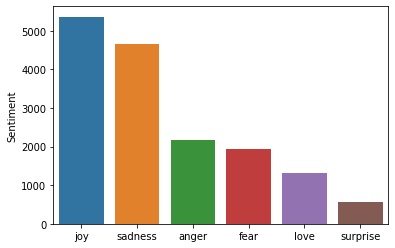

In [25]:
#Train distributions targets sentiment
data = df_train.Sentiment.value_counts()
print(data)
sns.barplot(x = data.index, y = data)

In [26]:
#Encoding sentiments
encoded_dict = {'anger':0,'fear':1, 'joy':2, 'love':3, 'sadness':4, 'surprise':5}
df_train['Sentiment'] = df_train.Sentiment.map(encoded_dict)
df_test['Sentiment'] = df_test.Sentiment.map(encoded_dict)
df_valid['Sentiment'] = df_valid.Sentiment.map(encoded_dict)

In [27]:
df_train.head()

,Input,Sentiment
0,i didnt feel humiliated,4
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,4
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,3
4,i am feeling grouchy,0


In [28]:
df_test.head()

,Input,Sentiment
0,im feeling rather rotten so im not very ambitious right now,4
1,im updating my blog because i feel shitty,4
2,i never make her separate from me because i don t ever want her to feel like i m ashamed with her,4
3,i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived,2
4,i was feeling a little vain when i did this one,4


In [29]:
df_valid.head()

,Input,Sentiment
0,im feeling quite sad and sorry for myself but ill snap out of it soon,4
1,i feel like i am still looking at a blank canvas blank pieces of paper,4
2,i feel like a faithful servant,3
3,i am just feeling cranky and blue,0
4,i can have for a treat or if i am feeling festive,2


In [30]:
X_train = df_train.Input
y_train = df_train.Sentiment

X_test = df_test.Input
y_test = df_test.Sentiment

X_valid = df_valid.Input
y_valid = df_valid.Sentiment

## Preparing DATA

In [138]:
#Tokenize

nombre_modelo = 'bert-base-multilingual-uncased'
#nombre_modelo = 'distilbert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(nombre_modelo)
train_encodings = tokenizer(X_train.to_list(), truncation=True, padding=True, return_tensors="tf")

In [97]:
MAX_SEQUENCE_LENGTH=train_encodings['input_ids'].shape[1]

test_encodings = tokenizer(X_test.to_list(), truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors="tf")

valid_encondings = tokenizer(X_valid.to_list(), truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors="tf")

In [98]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))
valid_dataset = tf.data.Dataset.from_tensor_slices((
    dict(valid_encondings),
    y_valid
))


## Fine Tuning with BERT

In [99]:
N_SENTIMENT = len(encoded_dict)

#definimos modelo de clasificación
config = BertConfig.from_pretrained(nombre_modelo, hidden_dropout_prob=0.2, num_labels=N_SENTIMENT)

model = TFBertForSequenceClassification.from_pretrained(nombre_modelo, config=config)
model.bert.trainable = True #Freeze BERT layers

# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'distilbert']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['bert', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_262 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
Total params: 109,486,854
Trainable params: 109,486,854
Non-trainable params: 0
_________________________________________________________________


In [100]:
#main loop
batch_size=32
N_EPOCHS = 3
tracker = EmissionsTracker(project_name="BERT Sentiment Analysis: "+nombre_modelo,
                           output_dir="emissions/",
                           measure_power_secs=3600
                          )

tracker.start()

history=model.fit(train_dataset.batch(batch_size), epochs=N_EPOCHS, batch_size=batch_size, validation_data=test_dataset.batch(batch_size))

emissions: float = tracker.stop()
print(emissions)

[codecarbon INFO @ 15:34:12] [setup] RAM Tracking...
[codecarbon INFO @ 15:34:12] [setup] GPU Tracking...
[codecarbon INFO @ 15:34:12] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 15:34:12] [setup] CPU Tracking...
[codecarbon WARNING @ 15:34:12] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:34:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 15:34:15] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 15:34:15] >>> Tracker's metadata:
[codecarbon INFO @ 15:34:15]   Platform system: Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic
[codecarbon INFO @ 15:34:15]   Python version: 3.7.13
[codecarbon INFO @ 15:34:15]   Available RAM : 12.683 GB
[codecarbon INFO @ 15:34:15]   CPU count: 2
[codecarbon INFO @ 15:34:15]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 15:34:15]   GPU count: 1
[codecarbon INFO @ 15:34:15]   GPU mode

Epoch 1/3
500/500 [==============================] - 216s 380ms/step - loss: 1.5867 - accuracy: 0.3349 - val_loss: 1.4441 - val_accuracy: 0.4640
Epoch 2/3
500/500 [==============================] - 187s 374ms/step - loss: 1.1062 - accuracy: 0.5962 - val_loss: 0.6429 - val_accuracy: 0.7745
Epoch 3/3
500/500 [==============================] - 187s 374ms/step - loss: 0.4828 - accuracy: 0.8284 - val_loss: 0.3190 - val_accuracy: 0.8875


[codecarbon INFO @ 15:44:16] Energy consumed for RAM : 0.000795 kWh. RAM Power : 4.7559428215026855 W
[codecarbon INFO @ 15:44:16] Energy consumed for all GPUs : 0.016940 kWh. All GPUs Power : 101.385 W
[codecarbon INFO @ 15:44:16] Energy consumed for all CPUs : 0.007101 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:44:16] 0.024835 kWh of electricity used since the begining.


0.0034458958342614573


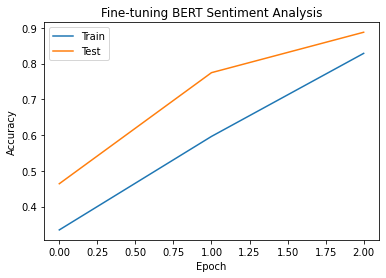

In [101]:
#Ploting results

import matplotlib.pyplot as plt
%matplotlib inline

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Fine-tuning BERT Sentiment Analysis')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Evaluation

In [102]:
#Training evaluation
score,acc = model.evaluate(train_dataset.batch(batch_size), verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

500/500 - 66s - loss: 0.2615 - accuracy: 0.9059 - 66s/epoch - 131ms/step
score: 0.26
acc: 0.91


In [103]:
#Test evaluation
score,acc = model.evaluate(test_dataset.batch(batch_size), verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

63/63 - 8s - loss: 0.3190 - accuracy: 0.8875 - 8s/epoch - 130ms/step
score: 0.32
acc: 0.89


In [104]:
#Valid evaluation
score,acc = model.evaluate(valid_dataset.batch(batch_size), verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

63/63 - 8s - loss: 0.3432 - accuracy: 0.8855 - 8s/epoch - 129ms/step
score: 0.34
acc: 0.89


## Predictions

In [105]:
# function to return key for any value
def get_key(val):
    for key, value in encoded_dict.items():
         if val == value:
             return key
 
    return "key doesn't exist"

In [106]:
predict = model.predict(valid_dataset.batch(batch_size))

In [107]:
predict_proba = tf.nn.softmax(predict.logits)
predict_classes = np.argmax(predict_proba, 1)
predict_classes

array([4, 4, 2, ..., 2, 3, 2])

In [108]:
df_valid2['predicted'] = [get_key(x) for x in predict_classes]

In [109]:
df_valid2.iloc[60:75]

,Input,Sentiment,predicted
60,i miss our talks our cuddling our kissing and the feelings that you can only share with your beloved,love,joy
61,i feel energetic and excited to see my results at the end of the week,joy,joy
62,i feel so shamed that i want to give up,sadness,sadness
63,i feel perfect with you on facebook href http www,joy,joy
64,i hope he will pull out the tissue paper himself but i feel like to him sunday will be just another day to be cute and wonderful,joy,joy
65,i also feel it is unfortunate that nearly all the readers of going to meet the man will be african americans unlike myself,sadness,sadness
66,i look and feel miserable,sadness,sadness
67,i try to share what i bake with a lot of people is because i love people and i want them to feel loved,love,love
68,i feel very strange today,fear,fear
69,i have no extra money im worried all of the time and i feel so beyond pathetic,sadness,sadness


Text(0.5, 1.0, 'Confusion Matrix')

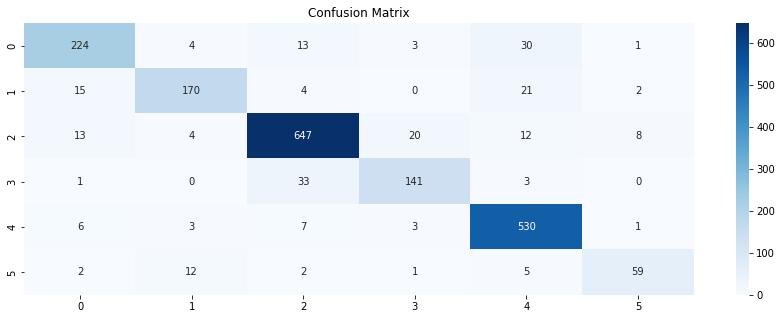

In [110]:
#Confusion matrix
cf_matrix = confusion_matrix(y_true=df_valid2.Sentiment, y_pred=df_valid2.predicted, labels = list(encoded_dict))
plt.figure(figsize=(15,5))
ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')
ax.set_title("Confusion Matrix")

## Random Sentences Prediction

In [111]:
#Simple text prediction
sentences = ["im feeling quite sad and sorry for myself but ill snap out of it soon", 
             "Today is my cousin's birthday party, I'm happy now", "I'm so lonely today, need some company", 
             "im updating my blog because i feel shitty", "I'm furious now, need to punch someone"]

In [112]:
predict_sentences = tokenizer(sentences, truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors="tf")
predict_dataset = tf.data.Dataset.from_tensor_slices((
    dict(predict_sentences),
))

In [113]:
predict = model.predict(predict_dataset.batch(batch_size))
predict_proba = tf.nn.softmax(predict.logits)
predict_classes = np.argmax(predict_proba, 1)

In [114]:
for i in range(len(predict_classes)):
  print(sentences[i],": ",get_key(predict_classes[i]))

im feeling quite sad and sorry for myself but ill snap out of it soon :  sadness
Today is my cousin's birthday party, I'm happy now :  joy
I'm so lonely today, need some company :  sadness
im updating my blog because i feel shitty :  sadness
I'm furious now, need to punch someone :  anger


## Saving model

In [131]:
import os

#creating model folder
try:
  os.mkdir("model/"+nombre_modelo+"/")
except:
  pass

In [132]:
#Saving with keras H5 format
model.save_weights('model/'+nombre_modelo+'/')

In [118]:
#testing reconstruction model
model_infer = TFBertForSequenceClassification.from_pretrained(nombre_modelo, config=config)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'distilbert']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['bert', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [119]:
model_infer.load_weights('model/'+nombre_modelo)

In [120]:
#Simple text prediction
sentences = ["im feeling quite sad and sorry for myself but ill snap out of it soon", 
             "Today is my cousin's birthday party, I'm happy now", "I'm so lonely today, need some company", 
             "im updating my blog because i feel shitty", "I'm furious now, need to punch someone"]

In [121]:
predict_sentences = tokenizer(sentences, truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors="tf")
predict_dataset = tf.data.Dataset.from_tensor_slices((
    dict(predict_sentences),
))

In [122]:
predict = model_infer.predict(predict_dataset.batch(batch_size))
predict_proba = tf.nn.softmax(predict.logits)
predict_classes = np.argmax(predict_proba, 1)

In [124]:
for i in range(len(predict_classes)):
  print(sentences[i],": ",get_key(predict_classes[i]))

im feeling quite sad and sorry for myself but ill snap out of it soon :  sadness
Today is my cousin's birthday party, I'm happy now :  joy
I'm so lonely today, need some company :  sadness
im updating my blog because i feel shitty :  sadness
I'm furious now, need to punch someone :  anger


In [125]:
!zip -r model_distilbert.zip model/distilbert-base-uncased


  adding: model/distilbert-base-uncased/ (stored 0%)


In [126]:
!ls -lh


total 1.3G
drwxr-xr-x 2 root root 4.0K Jul 29 14:17 data
drwxr-xr-x 2 root root 4.0K Jul 29 14:32 emissions
drwxr-xr-x 4 root root 4.0K Jul 29 15:54 model
-rw-r--r-- 1 root root  210 Jul 29 15:55 model_distilbert.zip
-rw-r--r-- 1 root root 1.3G Jul 29 15:15 model.zip
drwxr-xr-x 1 root root 4.0K Jul 13 13:43 sample_data


In [130]:
!ls -lh model/

total 3.1G
drwxr-xr-x 2 root root 4.0K Jul 29 15:30 bert-base-multilingual-uncased
-rw-r--r-- 1 root root 1.9G Jul 29 15:06 bert_sentiment_model.data-00000-of-00001
-rw-r--r-- 1 root root  44K Jul 29 15:06 bert_sentiment_model.index
-rw-r--r-- 1 root root  103 Jul 29 15:54 checkpoint
drwxr-xr-x 2 root root 4.0K Jul 29 15:58 distilbert-base-uncased
-rw-r--r-- 1 root root 1.3G Jul 29 15:54 distilbert-base-uncased.data-00000-of-00001
-rw-r--r-- 1 root root  44K Jul 29 15:54 distilbert-base-uncased.index
